## Домашняя работа 6
фев'24
<hr>

### Часть 1. EDA

<br>Скачайте данные с Kaggle по ценам на жильё в Airbnb в Нью-Йорке:
<br>Пройдите по основным шагам работы с данными:
<ul><li>выкиньте ненужные признаки: id, name, host_id, host_name, last_review</li>
<li>визуализируйте базовые статистики данных: распределения признаков, матрицу попарных корреляций, постройте pair plots</li>
<li>про результатам анализа произведите предобработку переменных</li></ul>

In [1]:
# !pip install numpy pandas seaborn matplotlib plotly scikit-learn kaggle
# !pip install pyarrow # !!!!!!!!!!!!!!!!!

In [2]:
%%time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')

import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML, display


Wall time: 1.99 s


In [3]:
def short_describe(df, sample_size=5, repiter=125):
    repiter='>'*repiter
    nRow, nCol = df.shape
    display(HTML(f'<b>There are {nRow} rows and {nCol} columns<br>Duplicates: {df.duplicated().sum()}</b><hr>'))
    d_test=df.sample(n=sample_size, random_state=42).T
    d_test['datatypes']=df.dtypes
    d_describe=df.describe(include='all').T
    
    for i in ['count','min','mean','max','std', 'unique', 'freq']:
        d_test[i]=d_describe[i]
        if i in ['min','mean',]:
            d_test[i].fillna('-', inplace=True)

    d_test['max'].fillna(d_test['unique'], inplace=True)
    d_test['std'].fillna(d_test['freq'], inplace=True)
    d_test.rename(columns = {'max':'max / unique','std':'std / freq'}, inplace = True)
    d_test=d_test.drop(columns=['unique','freq'])
    
    d_test['nulls']=df.isnull().sum()
    
    display(d_test)
    
    lst_num = df.select_dtypes(include='number').columns.tolist()
    lst_str = df.select_dtypes(include='object').columns.tolist()
    
    display(HTML("<hr><b>Null values</b>"))
    sns.heatmap(df.isnull().T,cbar=True,cmap='gray_r',xticklabels=False)
    plt.show()
    
    display(HTML(f'<hr><b>Numeric columns ({len(lst_num)}):</b>'))
    print(lst_num)
    display(HTML(f'<hr><b>String columns ({len(lst_str)}):</b>'))
    print(lst_str)

    
    display(HTML("<hr>"))
    return lst_num, lst_str

,879,44383,15394,43230,16332,datatypes,count,min,mean,max / unique,std / freq,nulls
neighbourhood_group,Brooklyn,Queens,Manhattan,Manhattan,Manhattan,object,48895,-,-,5.00000,21661.000000,0
neighbourhood,Kensington,Ridgewood,Hell's Kitchen,Financial District,East Harlem,object,48895,-,-,221.00000,3920.000000,0
latitude,40.64354,40.70666,40.76116,40.70763,40.79658,float64,48895.0,40.49979,40.728949,40.91306,0.054530,0
longitude,-73.97777,-73.90779,-73.99016,-74.0105,-73.93287,float64,48895.0,-74.24442,-73.95217,-73.71299,0.046157,0
room_type,Entire home/apt,Private room,Private room,Entire home/apt,Entire home/apt,object,48895,-,-,3.00000,25409.000000,0
price,89,30,120,470,199,int64,48895.0,0.0,152.720687,10000.00000,240.154170,0
minimum_nights,3,21,2,2,2,int64,48895.0,1.0,7.029962,1250.00000,20.510550,0
number_of_reviews,62,0,17,5,30,int64,48895.0,0.0,23.274466,629.00000,44.550582,0
reviews_per_month,0.71,NaN,0.43,1.88,0.8,float64,38843.0,0.01,1.373221,58.50000,1.680442,10052
calculated_host_listings_count,1,1,1,327,1,int64,48895.0,1.0,7.143982,327.00000,32.952519,0


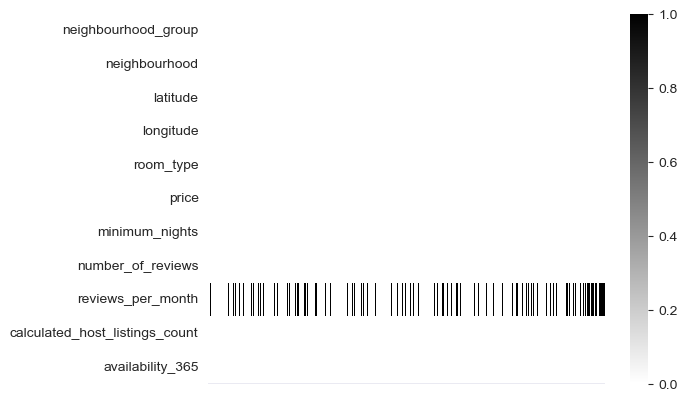

['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']


['neighbourhood_group', 'neighbourhood', 'room_type']


Wall time: 1.52 s


In [4]:
%%time

strFileName='AB_NYC_2019.csv'

# topNrows = 5000
# df = pd.read_csv(strFileName, delimiter=',', nrows = topNrows)

df = pd.read_csv(strFileName, delimiter=',', engine='pyarrow')

df=df.drop(columns=['id', 'name', 'host_id', 'host_name', 'last_review'])

cols_num, cols_str= short_describe(df)

<hr>

### Test correlation on sample

In [5]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df=df[cols_num], crit=0.85, method='spearman'):    
    au_corr = df.corr(method=method).abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[au_corr>crit]


In [6]:
crit=0.8
corr_df=df[cols_num].sample(n=1000,random_state=42)
result=get_top_abs_correlations(df=corr_df, crit=crit, method='pearson')
display(HTML(f'<b>Strong correlation (>{crit}): {result.shape[0]} pairs</b><hr>'))
print(result)

Series([], dtype: float64)


The most likely candidate for drop is field <b>number_of_reviews</b>,<br>
which is obviously closely related to field <b>reviews_per_month</b>

#CODE

drop_candidate='number_of_reviews'

df=df.drop(columns=drop_candidate)

cols_num.remove(drop_candidate)


<hr>

### Triangular correlation matrix

In [7]:
corr_df= df.corr(method='pearson').abs()
df_lt = corr_df.where(np.tril(np.ones(corr_df.shape)).astype(np.bool))
df_lt.style.background_gradient()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
latitude,1.000000,nan,nan,nan,nan,nan,nan,nan
longitude,0.084788,1.000000,nan,nan,nan,nan,nan,nan
price,0.033939,0.150019,1.000000,nan,nan,nan,nan,nan
minimum_nights,0.024869,0.062747,0.042799,1.000000,nan,nan,nan,nan
number_of_reviews,0.015389,0.059094,0.047954,0.080116,1.000000,nan,nan,nan
reviews_per_month,0.010142,0.145948,0.030608,0.121702,0.549868,1.000000,nan,nan
calculated_host_listings_count,0.019517,0.114713,0.057472,0.127960,0.072376,0.009421,1.000000,nan
availability_365,0.010983,0.082731,0.081829,0.144303,0.172028,0.185791,0.225701,1.000000


### Nominal feaches

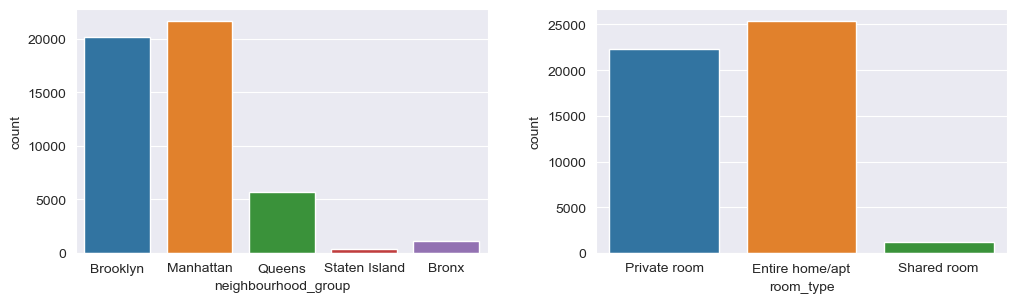

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
fig.tight_layout(h_pad=5,w_pad=5)
sns.countplot(ax=ax[0],x='neighbourhood_group',data=df)
sns.countplot(ax=ax[1],x='room_type',data=df)
plt.show()

In [9]:
pivot_df=pd.pivot_table(df, values='price',
                        index=['neighbourhood_group'],columns=['room_type'],
                        aggfunc={"mean","count","std"})
display(pivot_df.style.background_gradient())

<hr>

### Numeric feaches

#### Price

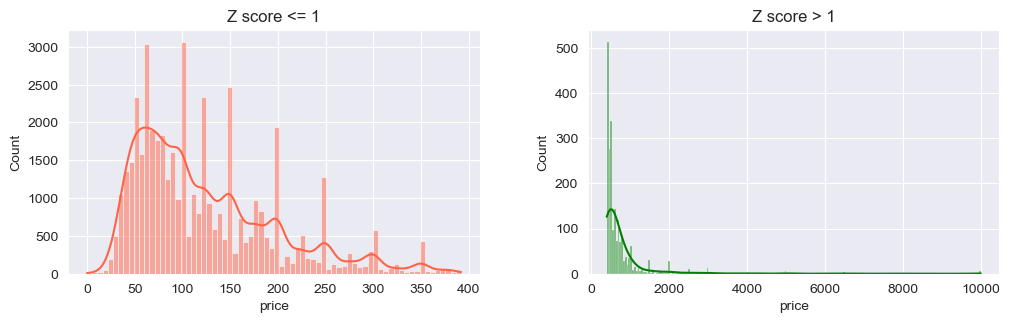

In [10]:
from scipy.stats import zscore

fig, ax = plt.subplots(1, 2, figsize=(10,3))
fig.tight_layout(h_pad=5,w_pad=5)

crit=1
sns.histplot(ax=ax[0],
             data=df.where(zscore(df['price']) <= crit),
             kde=True,x='price', color='tomato')
ax[0].set_title(f'Z score <= {crit}')

sns.histplot(ax=ax[1],
             data=df.where(zscore(df['price']) > crit),
             kde=True,x='price', color='green')
ax[1].set_title(f'Z score > {crit}')

display(HTML(f'<img src="Normal_distribution_and_scales.gif" width="500"/>'))

plt.show()

Wall time: 11.7 s


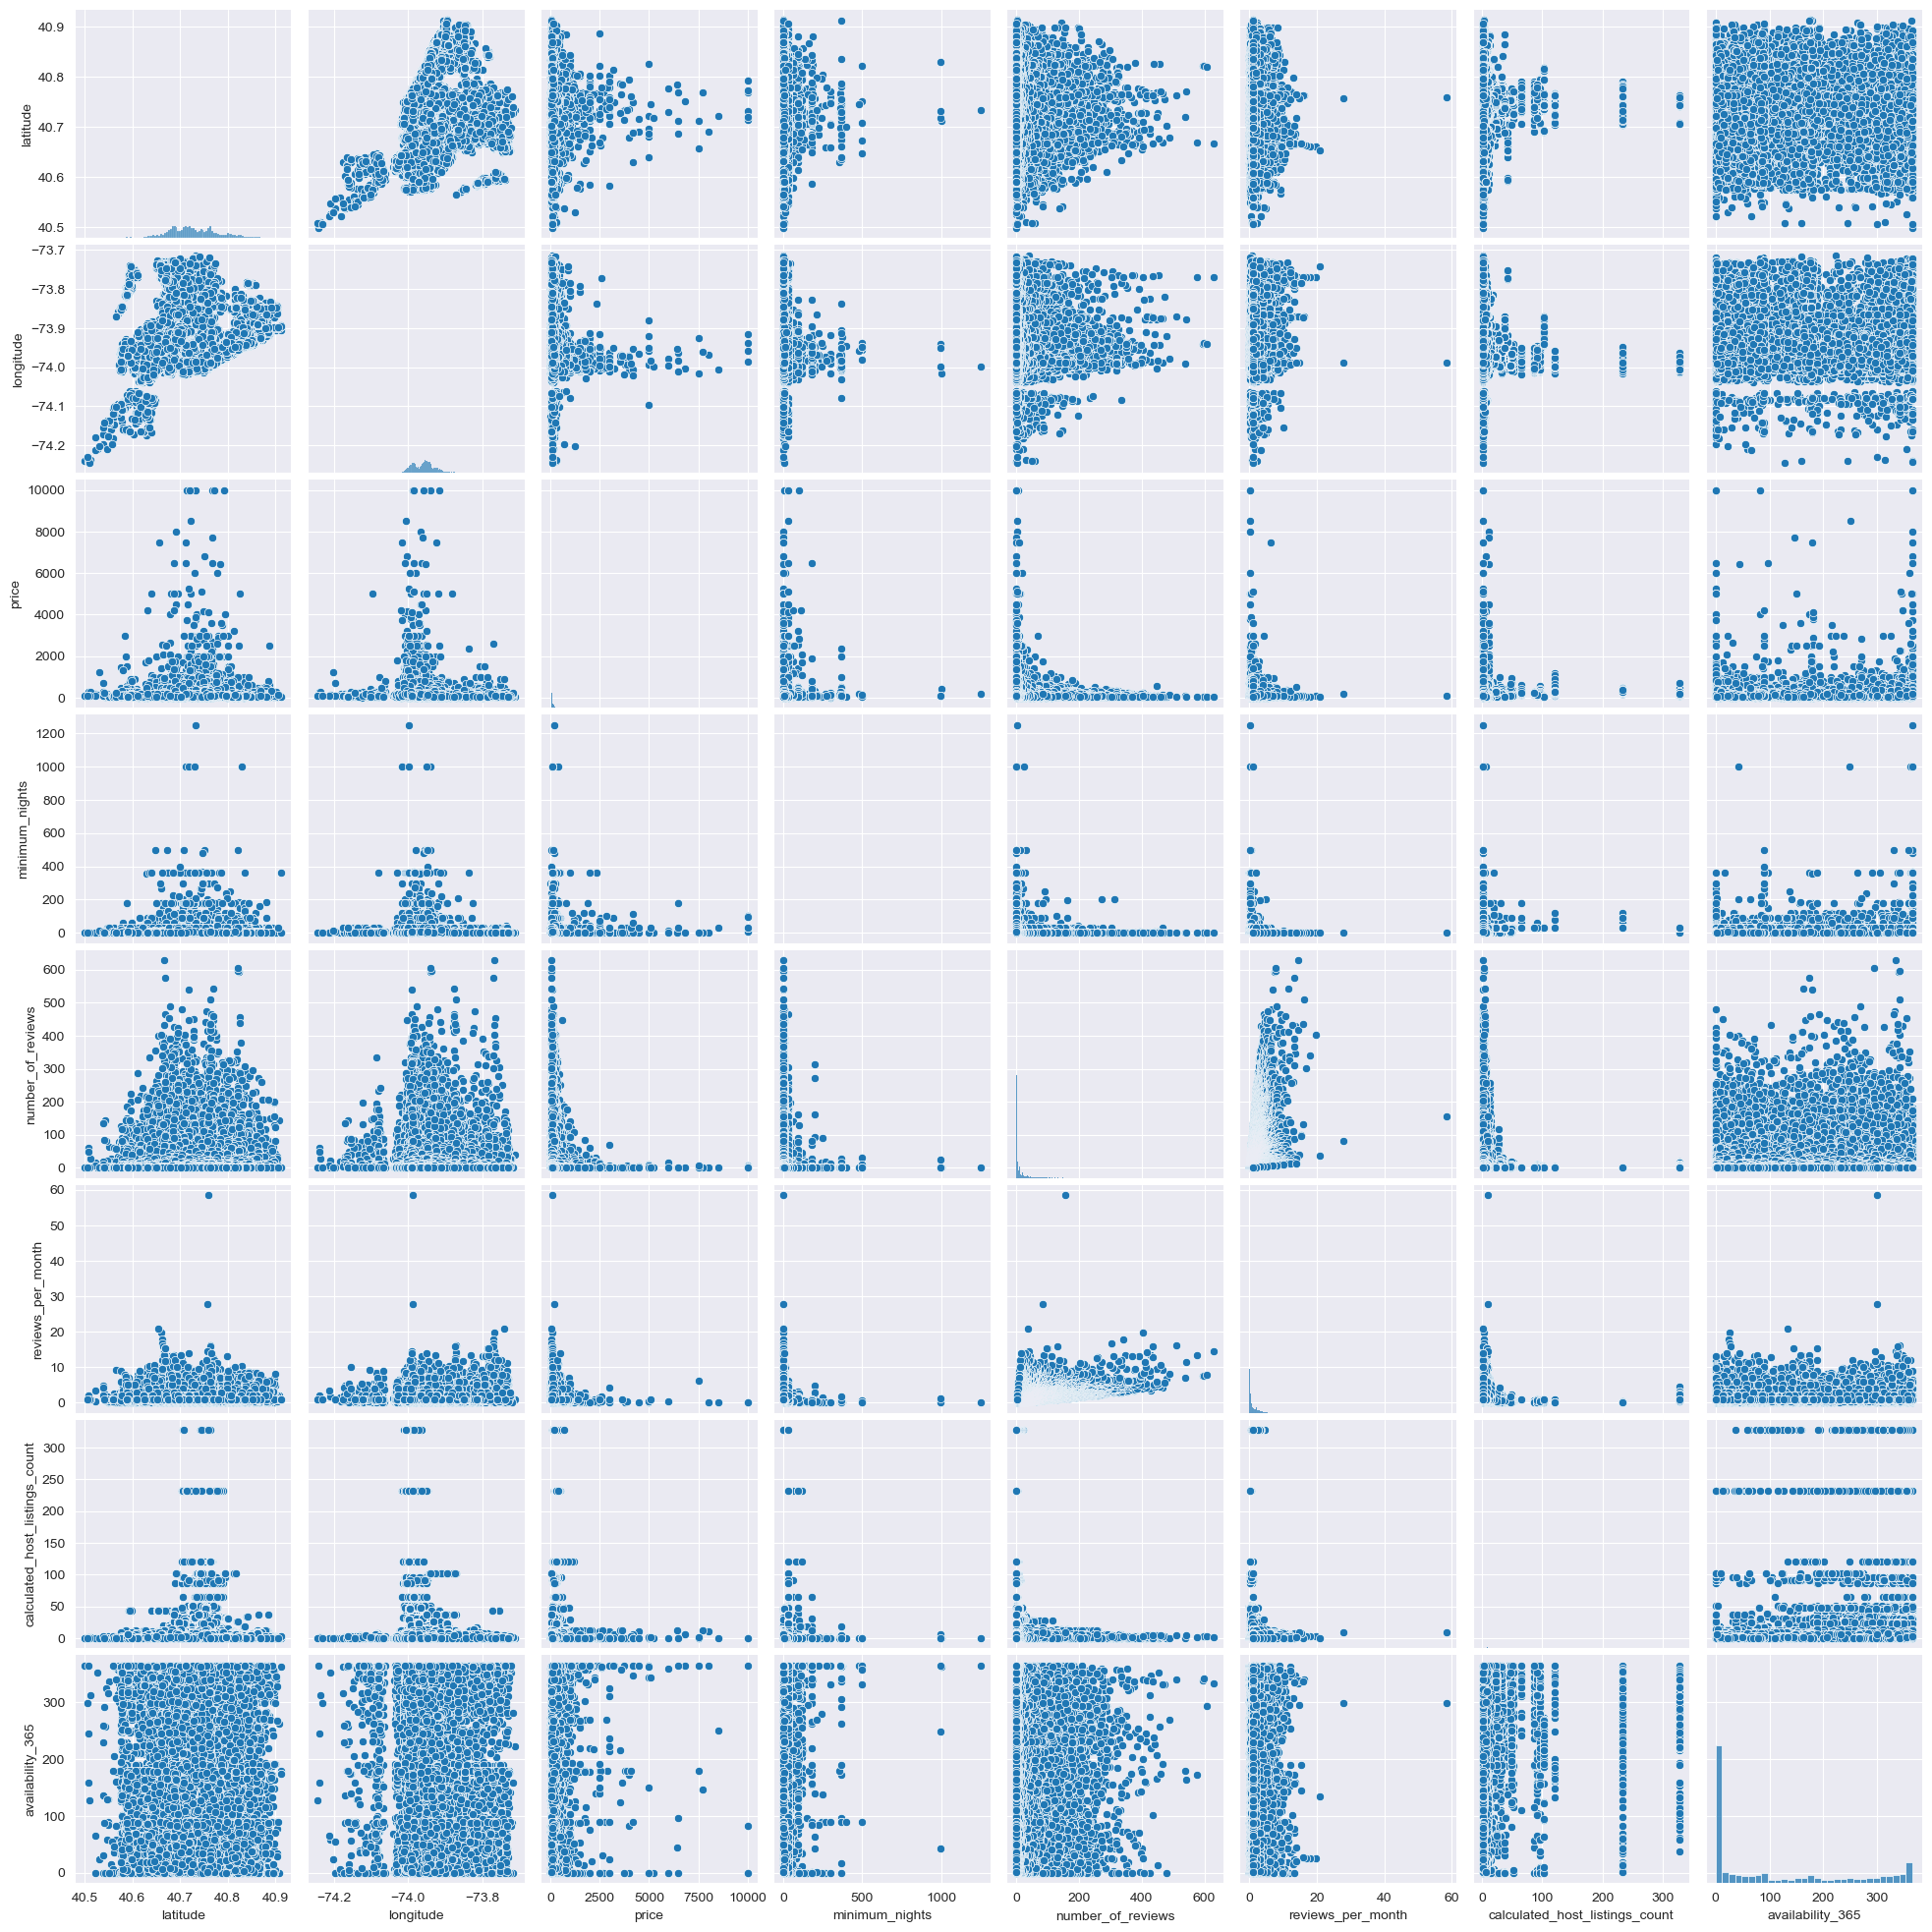

In [11]:
%%time
sns.pairplot(data=df)

<hr>

### Часть 2. Preprocessing & Feature Engineering

<br>Ваша цель получить как можно более высокие метрики качества (можно взять несколько, R2, MAE, RMSE), сконцентрировавшись на преобразовании признаков.
<br>Опробуйте различные техники:
<ul><li>работа с категориальными переменными (можно начать с dummy);</li>
<li>замена аномалий;</li>
<li>различные варианты шкалирования непрерывных переменных (StandardScaler, RobustScaler, и.т.д.);</li>
<li>обратите внимание на распределение целевой переменной, возможно, с ней тоже можно поработать;</li>
</ul>
Попробуйте на основании имеющихся переменных создать новые, которые могли бы улучшить качество модели. Например, можно найти координаты Манхэттена (самого дорогого района) и при помощи широты и долготы, а также евклидового расстояния создать новую переменную - расстояние от квартиры до этого района. Возможно, такой признак будет работать лучше, чем просто широта и долгота.

### Price

In [12]:
df_z_price=df[['neighbourhood_group','room_type','price']]

df_z_price['z_price']=zscore(df_z_price['price']).abs()
df_z_price['z_price_group']=round(df_z_price['z_price'],0)
df_z_price[df_z_price['z_price_group']>3]=3

display(df_z_price[df_z_price['z_price']>1].describe().T)

display(df_z_price.value_counts('z_price_group',normalize=True).to_frame().T)

pivot_df=pd.pivot_table(df_z_price, values='price',
                        columns=['z_price_group'], index=['room_type'],
                        aggfunc={"mean","count","min"})
display(pivot_df)


,count,mean,std,min,25%,50%,75%,max
price,2137.0,460.752925,234.143792,3.000000,400.000000,475.000000,600.000000,990.00000
z_price,2137.0,1.826936,0.742583,1.000531,1.233717,1.446083,2.487092,3.48646
z_price_group,2137.0,1.722040,0.822464,1.000000,1.000000,1.000000,2.000000,3.00000


z_price_group,0.0,1.0,2.0,3.0
0,0.885285,0.093547,0.010778,0.01039


count                              mean              \
z_price_group        0.0     1.0    2.0    3.0         0.0         1.0   
room_type                                                                
3                    NaN     NaN    NaN  321.0         NaN         NaN   
Entire home/apt  21047.0  3478.0  473.0  156.0  151.774552  349.733755   
Private room     21394.0   789.0   53.0   28.0   78.818033  162.542459   
Shared room        845.0   307.0    1.0    3.0   68.353846   50.208469   

                                          min                     
z_price_group           2.0         3.0   0.0  1.0    2.0    3.0  
room_type                                                         
3                       NaN    3.000000   NaN  NaN    NaN    3.0  
Entire home/apt  634.947146  847.923077  33.0  0.0  515.0  760.0  
Private room     633.641509  872.142857  33.0  0.0  515.0  794.0  
Shared room      725.000000  800.000000  33.0  0.0  725.0  800.0

In [ ]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

df[df['target_price']>=]=


<b>depricated:</b> <strike>'latitude', 'longitude' - to one field. </strike>

<hr>

### Часть 3. Моделирование

<br>Отложите 30% данных для тестирования.
<br>Постройте модели простой линейной регрессии, RidgeCV, LassoCV и ElasticNetCV.
<br>Измерьте качество каждой и визуализируйте важность признаков.
<br>Сделайте интересные выводы :)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

results=pd.DataFrame()

def metrics_df(results=results, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    d={
        'model' : type(model).__name__,
        'MAE'   : mean_absolute_error(y_test, y_pred),
        'MSE'   : mean_squared_error(y_test, y_pred),
        'R2'    : r2_score(y_test, y_pred),
    }
    ret_df=pd.concat([results,
                      pd.DataFrame(data=d)],
                     ignore_index=True)
    return ret_df

In [ ]:
from sklearn.model_selection import train_test_split
test_size=.3
train_size=1-test_size
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, shuffle=True, random_state=42)